# Module import

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, color, exposure, transform, img_as_float32
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import skimage

import hvplot.pandas

from PIL import Image
from skimage import io, color, exposure, transform, img_as_float32
import skimage

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
import umap
import umap.plot

from scipy import stats

from pathlib import Path
import os, sys

from dask import bag, diagnostics

from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))
import leukopy_lib as leuko
import leukopy_lib_EDA as eda
from importlib import reload
reload(leuko)
reload(eda)

Loading BokehJS ...

<module 'leukopy_lib_EDA' from '/home/marie-anne/code/Leukopy/notebooks/leukopy_lib_EDA.py'>

**Liste des variables du DF :**

- img_path : chemin d'accès de l'image

- cell_type : même information que label, en toutes lettres

- label : 11 classes de cellule 

|Cell type|Code|Barcelona|Raabin|Munich|
|---------|----|---------|------|------|
|neutrophils (segmented)| SNE|X| |X|
|eosinophils|              EO|X|X|X|
|basophils|                BA|X|X|X|
|lymphocytes|              LY|X|X|X|
|monocytes|                MO|X|X|X|
|metamyelocytes|          MMY|X| |X|
|myelocytes|               MY|X| |X|
|promyelocytes|           PMY|X| |X|
|band neutrophils|        BNE|X| |X|
|platelets|               PLT|X| | |
|erythroblasts|           ERB|X| |X|
    

- height : hauteur en nombre de pixels
- width : largeur en nombre de pixels
- mean_brightness : luminosité moyennée sur toute l'image (couleur)
- mean_luminance : luminosité moyennée sur toute l'image (niveaux de gris)


# Import

In [3]:
# path_folder = '../../data/dataset/' #remove if not needed
# df = leuko.load_df(path_folder, from_folder=True) # remove if not needed (already using csv)

path_csv = '../../data/PBC_dataset_normal_df_merged.csv'
# df.to_csv(path_csv, index=False)
df = leuko.load_df(path_csv)

df.head()

img_path label label_2     origin  height  \
0  ../../data/dataset/SNE/SNE_263049.jpg   SNE     SNE  barcelone     363   
1  ../../data/dataset/SNE/SNE_829664.jpg   SNE     SNE  barcelone     363   
2  ../../data/dataset/SNE/SNE_987578.jpg   SNE     SNE  barcelone     363   
3   ../../data/dataset/SNE/SNE_66862.jpg   SNE     SNE  barcelone     363   
4  ../../data/dataset/SNE/SNE_935764.jpg   SNE     SNE  barcelone     363   

   width  mean_brightness  mean_luminance  
0    360       200.803423        0.783345  
1    360       197.570620        0.766877  
2    360       197.110430        0.765792  
3    360       200.949015        0.783442  
4    360       188.113246        0.724006

In [4]:
df.nunique()

img_path           37689
label                 11
label_2              229
origin                 3
height                34
width                 32
mean_brightness    37651
mean_luminance     37672
dtype: int64

In [5]:
barca = df.copy()[df.origin=='barcelone']
munich = df.copy()[df.origin=='munich']
raabin = df.copy()[df.origin=='raabin']

## Distribution des classes

Text(0.5, 1.0, 'Class imbalance')

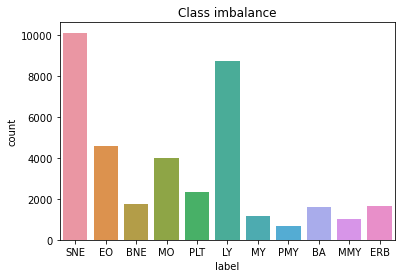

In [6]:
sns.countplot(x=df.label)
plt.title('Class imbalance')

Les classes ne sont pas équilibrées, il faudra peut-être avoir recours à de l'augmentation de données.

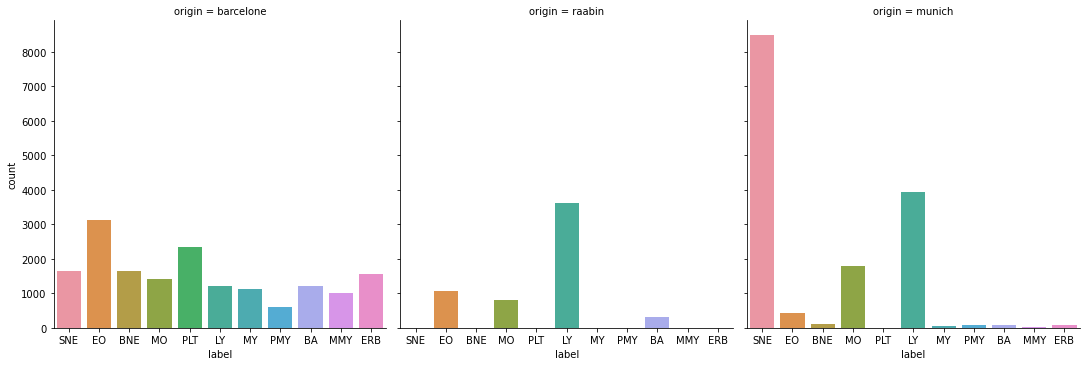

In [7]:
sns.catplot(x='label', data=df, kind='count', col='origin')

## Images aléatoires par classes

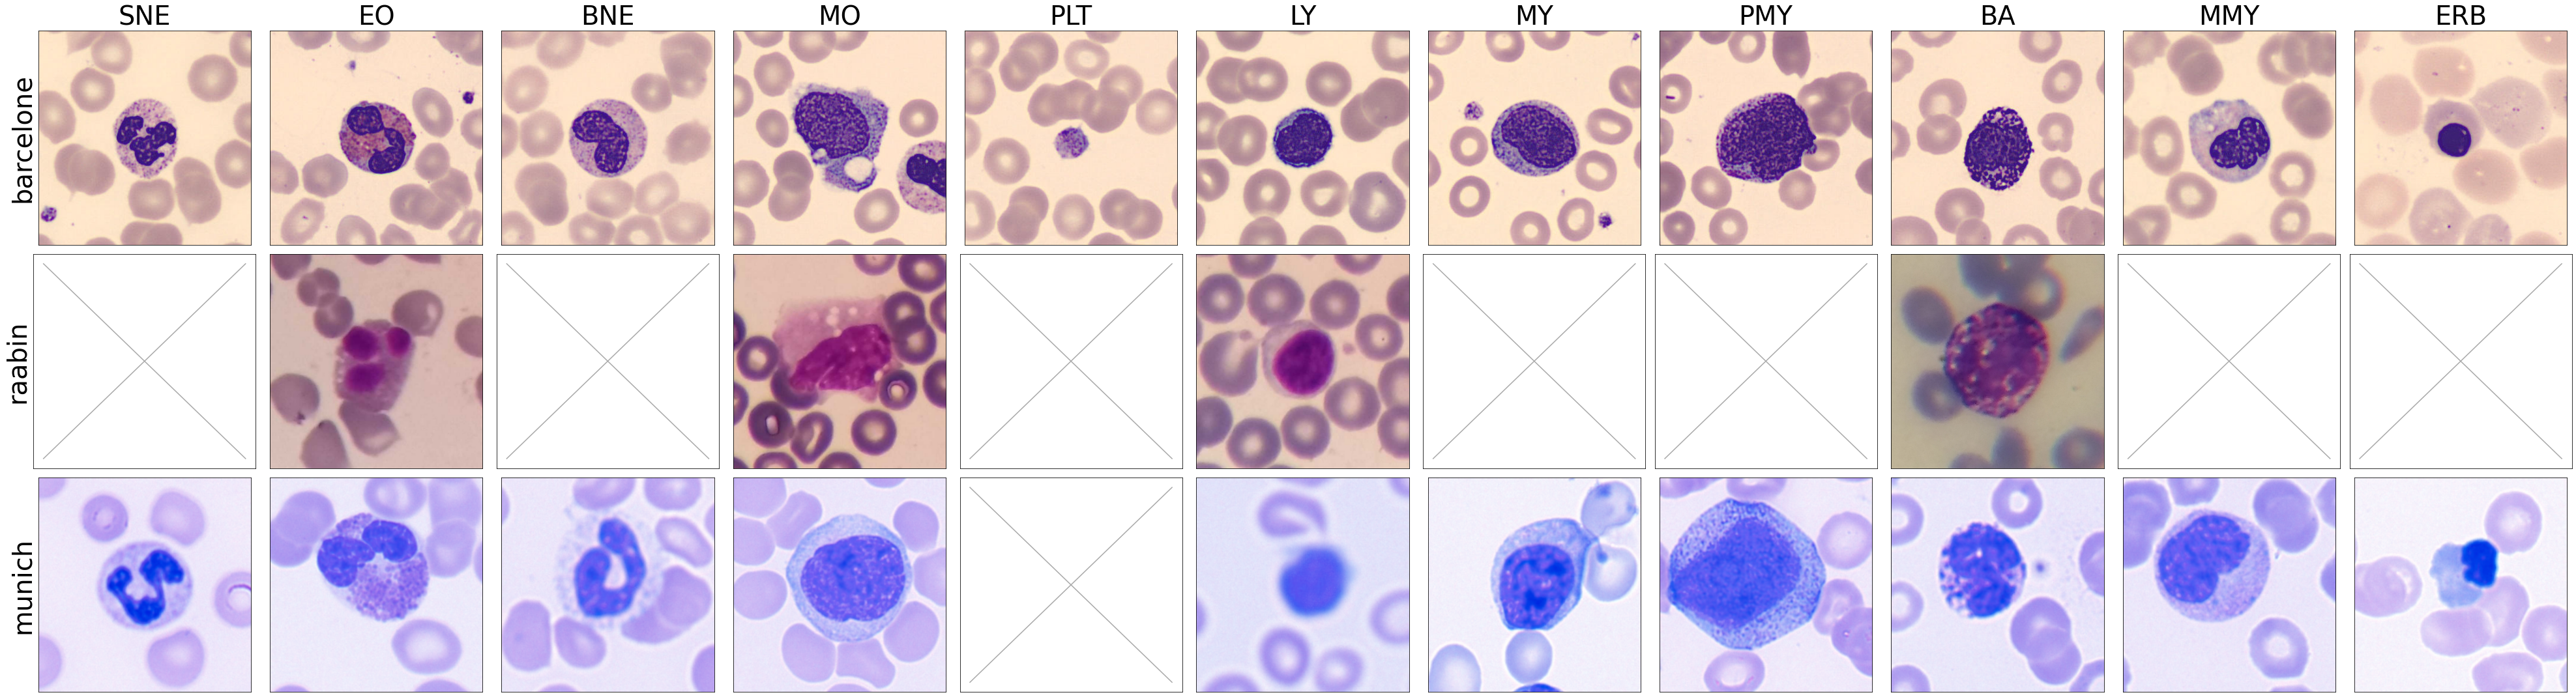

In [12]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
fig, axes = plt.subplots(nrows=3, ncols=11, figsize=(55, 15))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

for row, ori in enumerate(df.origin.unique()):
    for col, (ax, label) in enumerate(zip(axes[row].flatten(), df.label.unique())):
        try:
            img_path = np.random.choice(df[(df["label"] == label) &
                                         (df["origin"] == ori)]["img_path"])
            img = leuko.load_image(img_path)
            ax.imshow(img)
        except:
            ax.plot([0, 1], [0, 1], 'darkgrey')
            ax.plot([1, 0], [0, 1], 'darkgrey')
            
        if row == 0:
            ax.set_title(f'{label}', fontsize=40)
        if col == 0:
            ax.set_ylabel(f'{ori}', fontsize=40)

plt.tight_layout()
fig.savefig('../../streamlit/src/data/images/plot_ramdom_cells.jpg', )


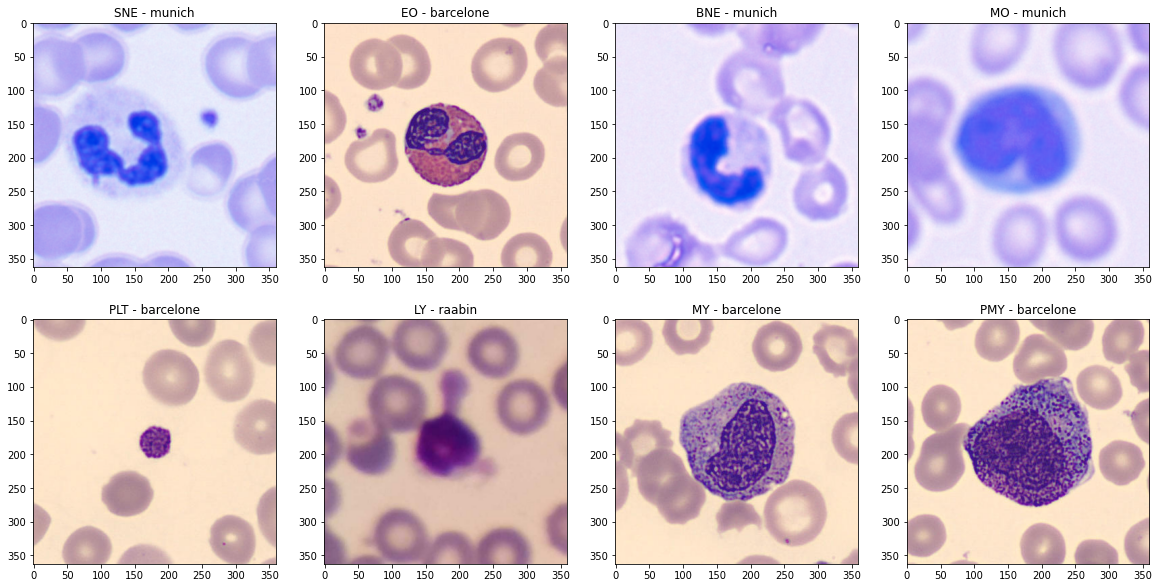

In [6]:
eda.plot_random_by_classes(df, origin=True)

On a un premier aperçu des différences entre chaque classe de cellules :
- couleur
- taille
- forme
- forme du noyau

A première vue, on peut remarquer des similitudes entre certaines types de cellules : par exemple MO et IG (avec BA, dans une moindre mesure), NEU et EO (forme du noyau, parfois coloration).

Des éléments peuvent venir parasiter l'information importante :
- globules rouges en fond, dont le nombre et l'aspect peuvebt différer fortement d'une image à l'autre,
- couleur de l'image : la majorité sont globalement roses, mais d'autres tirent vers le gris.

Les images sont au format RGB : M*N pixels + 3 canaux (rouge, vert, bleu) : on remarque que toutes n'ont pas la même taille.

On remarque aussi que les images de différentes sources présentent différente colorations/luminosité.

## Distribution des tailles d'images

In [7]:
sizes = df.groupby(['height', 'width']).agg(origin=('origin', 'unique'), 
                                    count=('img_path', 'count')
                                   )

In [8]:
sizes.origin = sizes.origin.astype('str')

In [9]:
sizes.hvplot.scatter(x='height', y='width', size='count', color='origin',
                     xlim=(300,610), ylim=(300,610), 
                     grid=True, 
                     height=500, width=600).options(line_alpha=0.7,
                                                    line_width=2,
                                                    fill_alpha=0.04)


:Scatter   [height]   (width,origin,count)

La majorité des images du dataset sont au format 363x360 ou 400x400.

Le dataset Rabbin montre des images ayant une distribution très variée et les images sont très grandes (meilleures résolution).
- pour la suite de l'exploration, les images seront redimensionnées en 360*360
- pour la modélisation, elles seront réduites au format 256*256 ou autres en fonction du modèle choisit

# Luminance

## Distribution de la luminosité

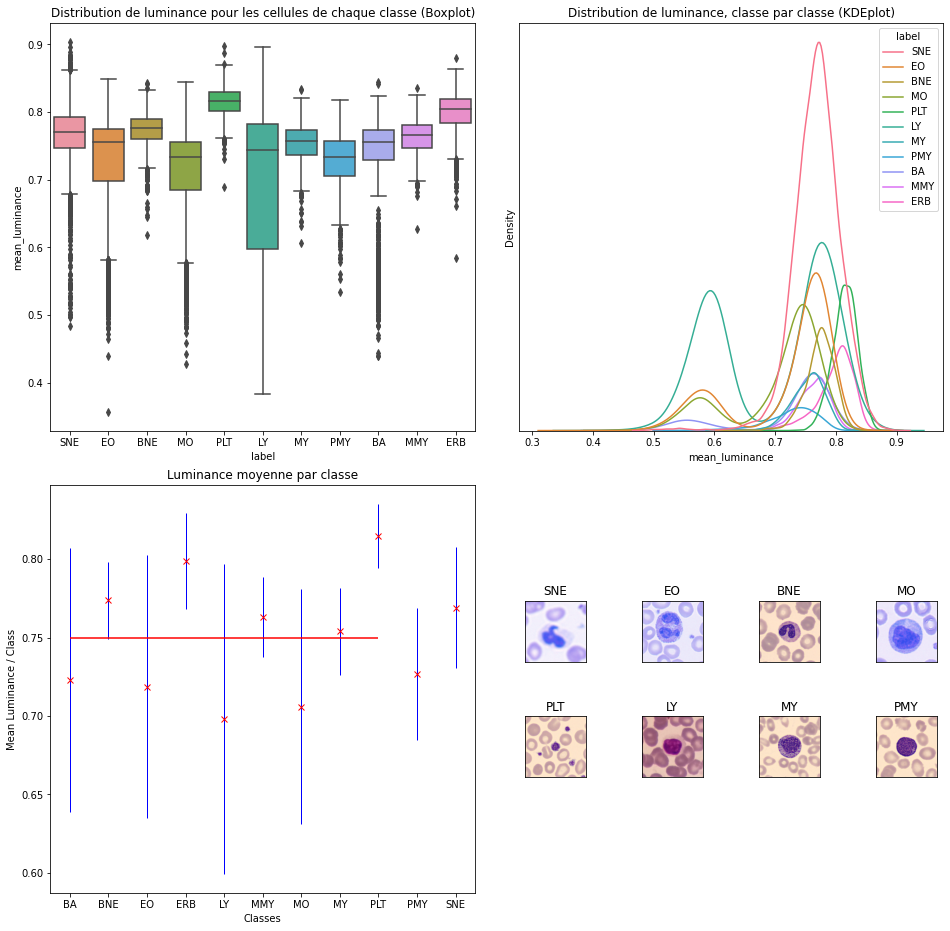

In [10]:
eda.plot_meanluminance_stats(df)

### Barcelone

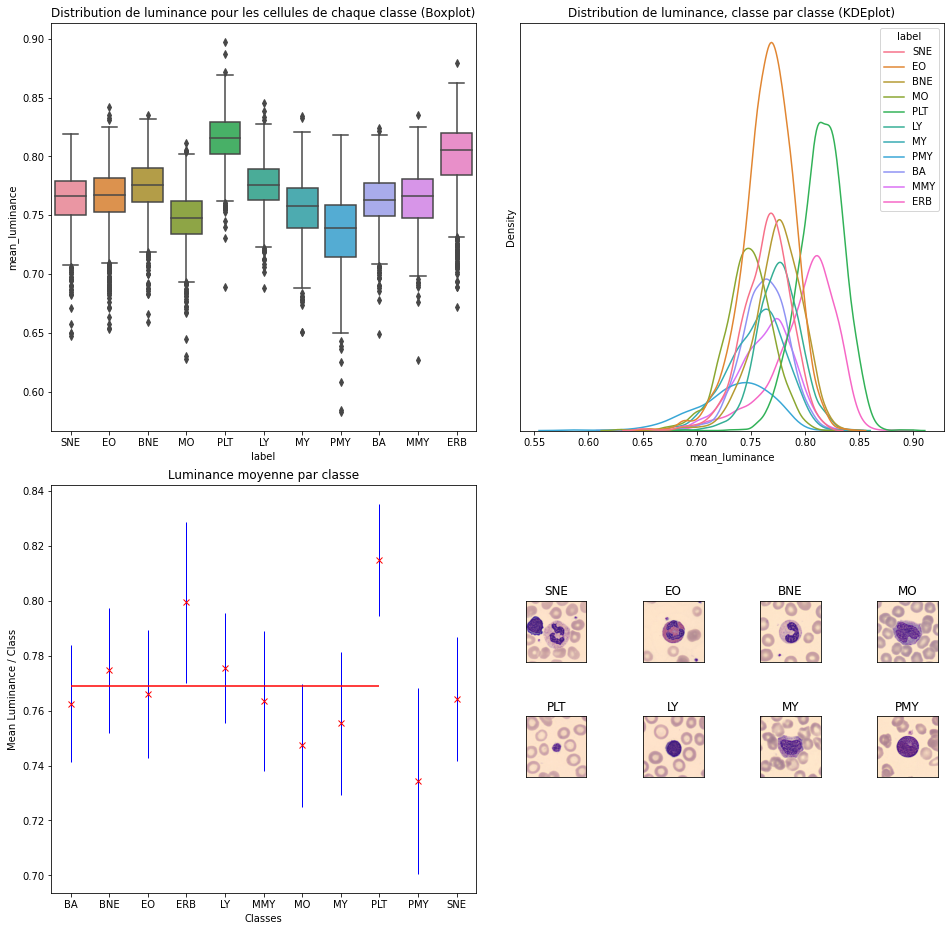

In [18]:
eda.plot_meanluminance_stats(barca)

### Munich

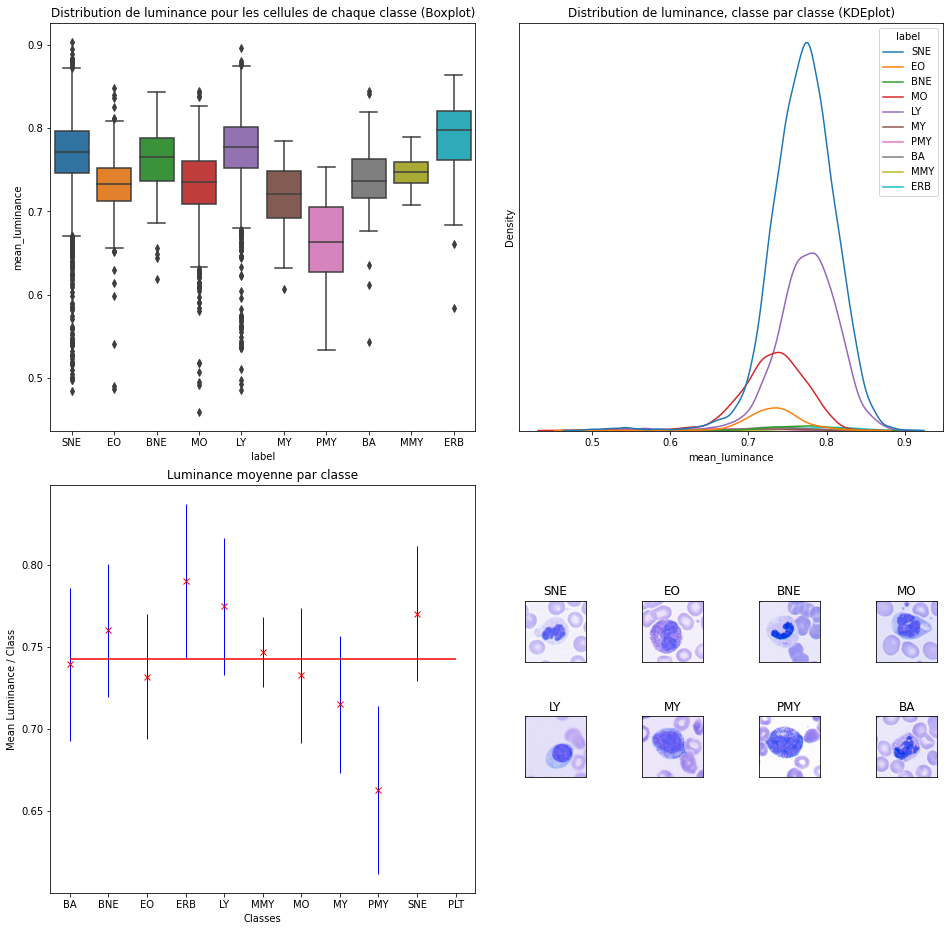

In [19]:
eda.plot_meanluminance_stats(munich)

### Raabin

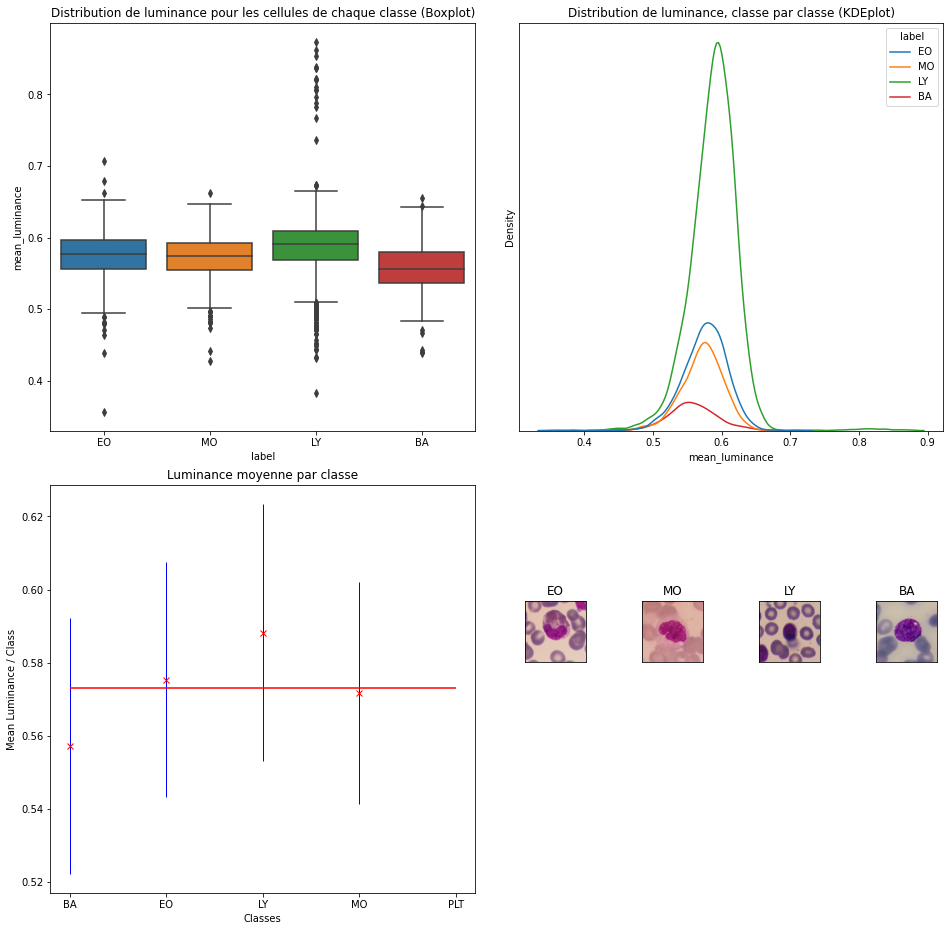

In [20]:
eda.plot_meanluminance_stats(raabin)

Cette analyse met en évidence les points suivants :
- deux classes sortent légèrement du lot : les plaquettes (PLT) et les érythroblastes (ERB) pour le dataset de Barcelone,
- toutes les classes présentent des outliers, essentiellement de faible luminosité.

L'obscurité sur nos images est liée à trois facteurs :
- la cellule d'intérêt (surtout son noyau lorsqu'il y en a un),
- les globules rouges en fond,
- dans une moindre mesure, la présence d'une ou plusieurs autres cellules d'intérêt, en périphérie de l'image.

Comme les globules rouges et les cellules "parasites" sont distribués aléatoirement d'une image à l'autre, leur présence ne doit pas vraiment influencer la luminosité moyenne d'une classe. On peut donc expliquer qualitativement les différences de luminosité moyenne d'une classe à l'autre en regardant un exemple pour chaque type de cellule :
- les plaquettes (PLT) sont les cellules les plus petites et sont en plus dépourvues de noyau : l'image dans sa globalité est donc moins sombre que pour les autres cellules ; les érythroblastes sontn plus volumineux, mais leur noyau (la partie la plus sombre) est relativement petit par rapport au volume de la cellule et par rapport aux autres types de cellules : les images ERB sont donc plus lumineuses que pour les autres classes, sauf PLT ;
- les images les plus sombres sont les granulocytes (IG) et les monocytes (MO), qui sont de grosses cellules avec des noyaux assez volumineux (et sombres) ;
- le noyau d'un lymphocyte (LY) occupe la quasi-totalité du volume de la cellule, qui est donc plutôt sombre, mais cette cellule est plutôt petite, l'image est donc en moyenne plus lumineuse qu'une image d'éosinophile (EO) ou de neutrophile (NEU), cellules dont le noyau a un volume similaire à celui d'un lymphocyte mais qui sont plus grosses que lui.

Il n'y a donc **probablement pas de biais de luminosité** d'une classe de cellules à l'autre.

## Outliers

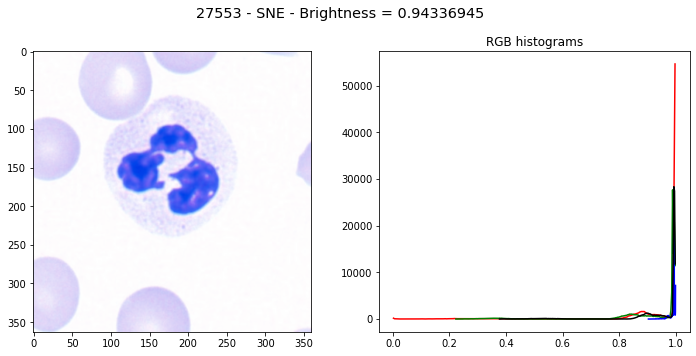

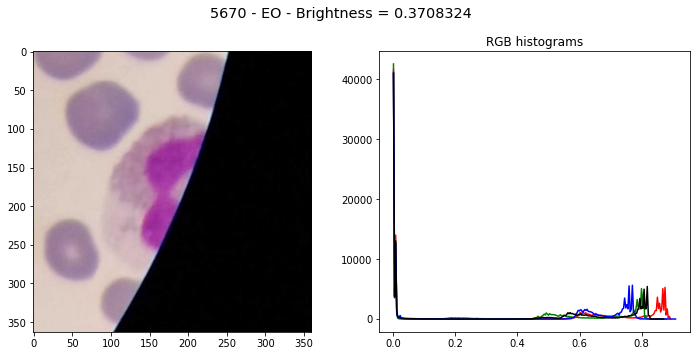

In [69]:
eda.plot_best_outliers(df, histos = True)

- L'image la plus lumineuse représente est issue du dataset de Munich. 
- L'image la plus sombre est du a l'obstruction de la caméra par la mauvaise mise en place de l'objectif du microscope.

On peut maintenant afficher quelques outliers pris au hasard dans le DataFrame :

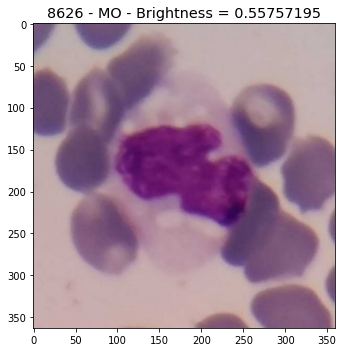

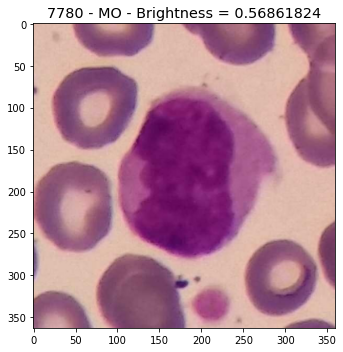

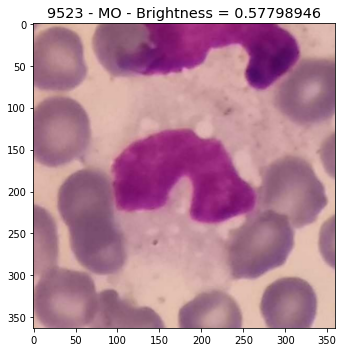

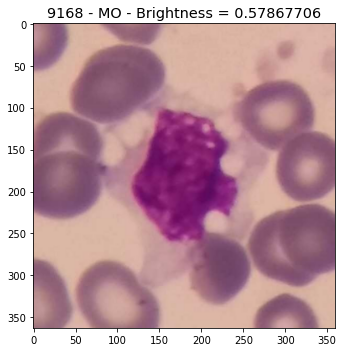

In [70]:
eda.plot_random_outliers(df, label = "MO")

On remarque que beaucoup des outliers sombres sont caractérisés par la présence d'un nombre important de globules rouges autour de la cellule d'intérêt, ou par la présence de plusieurs cellules à noyau. Quant aux outliers lumineux, 
ce sont des images dans lesquelles il y a très peu (voire aucun) de globules rouges.

## Exploration détaillée du dataset de Barcelone
### Cellules "moyennes"

On va maintenant représenter une cellule "moyenne" pour chaque type de cellule uniquement pour le dataset de Barcelone (celui qui présente une luminosité différente par type de cellule):

Number of cells in MO : 1420


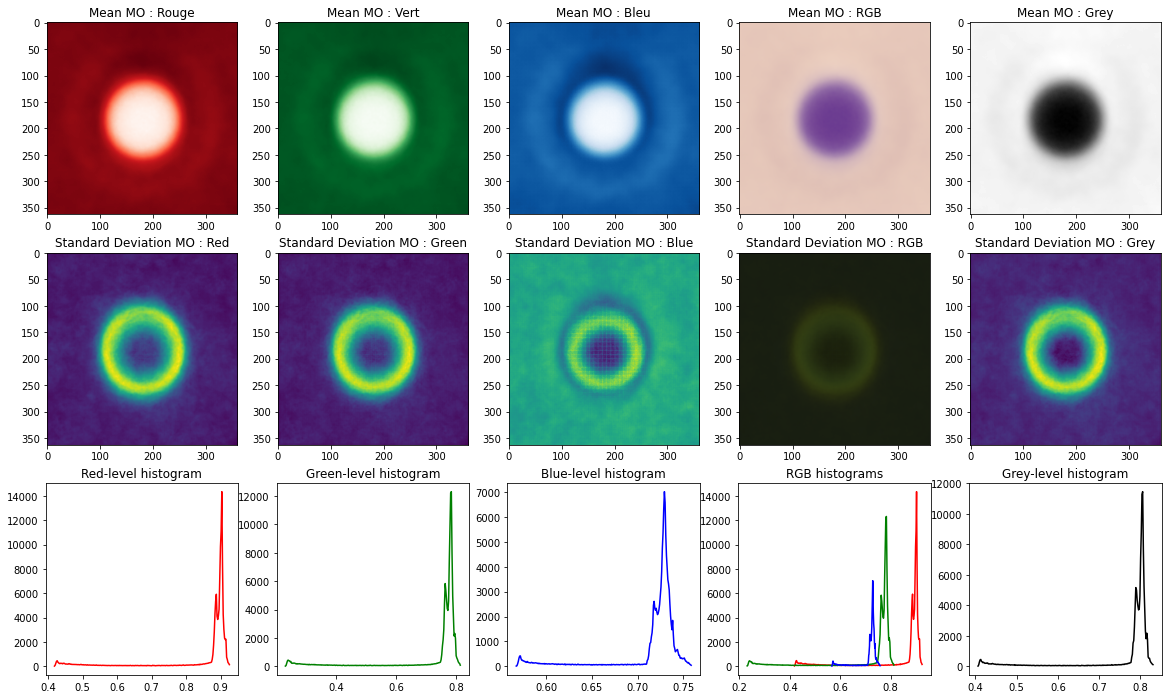

In [24]:
# Long, consomme de la RAM, sélectionner seulement une classe de la liste...

#labels = df['label'].unique().tolist()
labels = ['MO']
df_mean = eda.plot_mean_color_cell(barca, labels)

Number of cells in MO : 1420
Number of cells in ERB : 1551
Number of cells in PLT : 2348
Number of cells in BA : 1218
Number of cells in NEU : 3329
Number of cells in LY : 1214
Number of cells in EO : 3117
Number of cells in IG : 2895


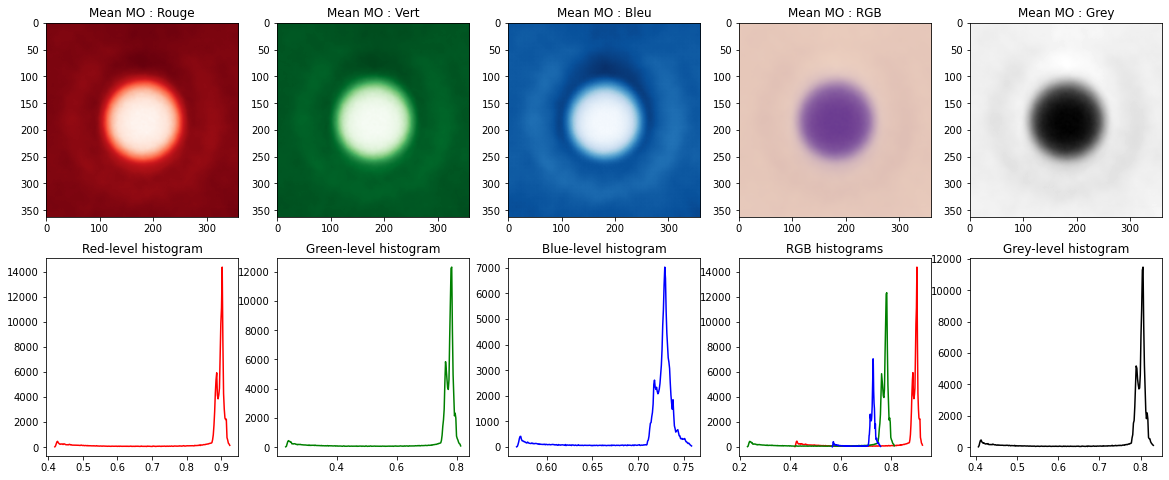

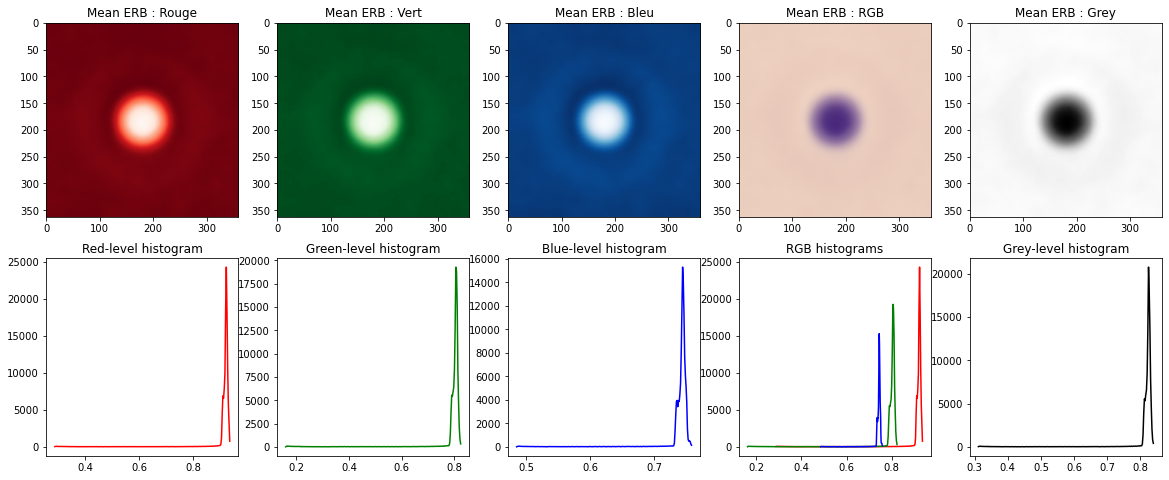

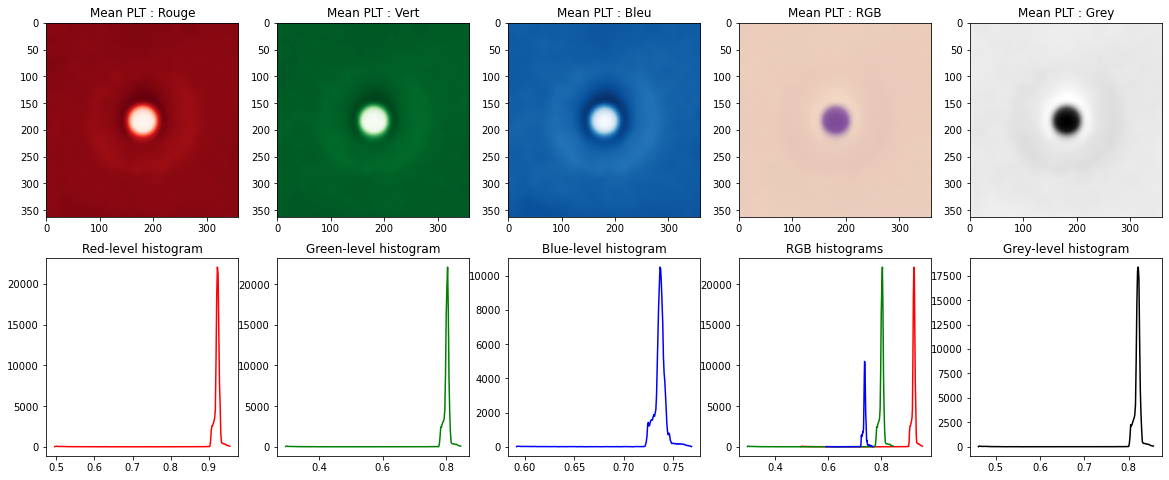

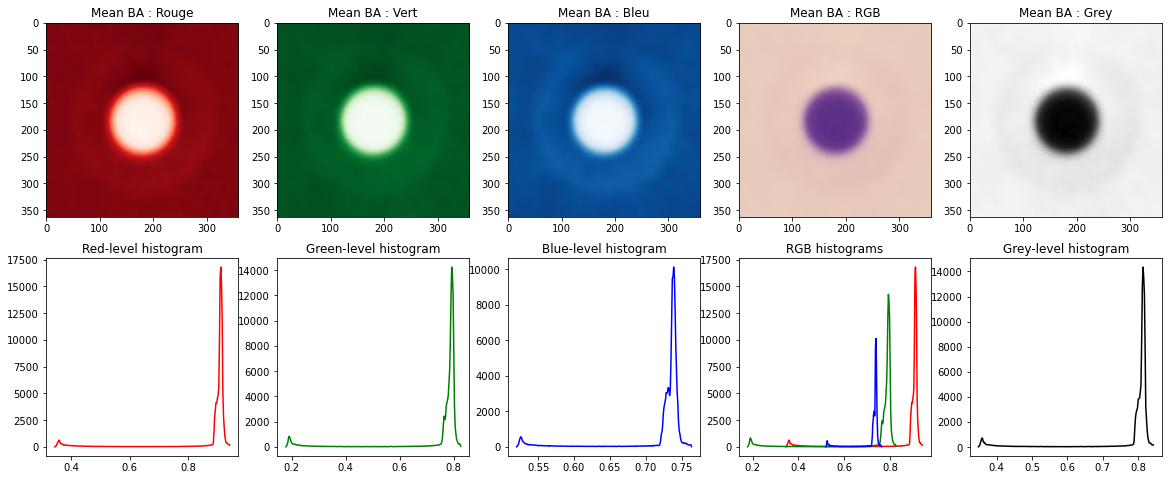

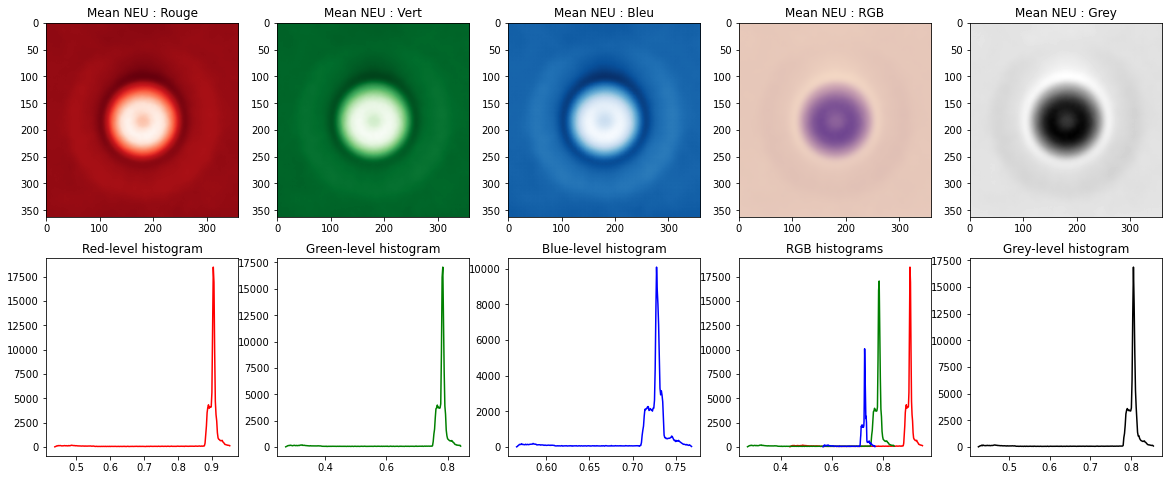

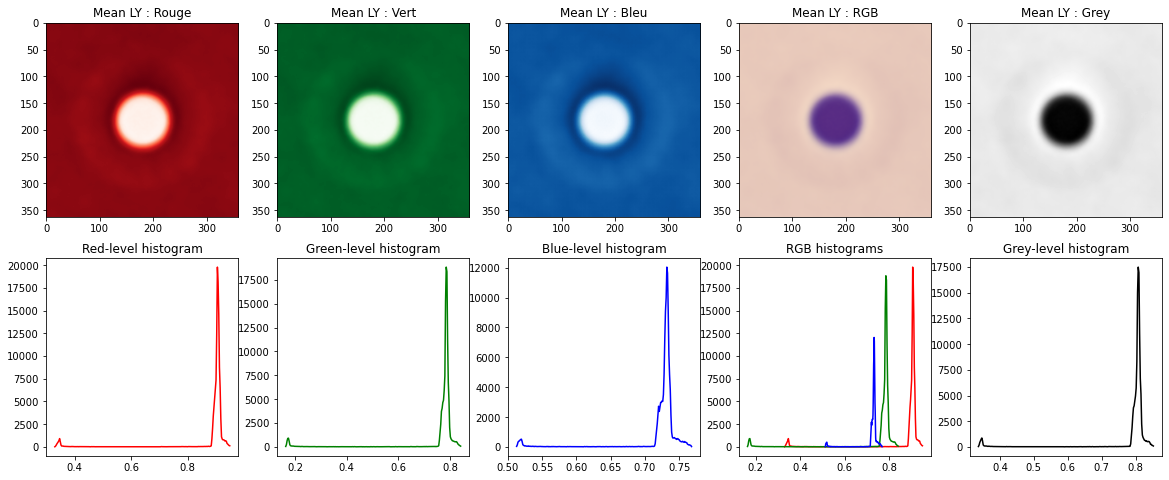

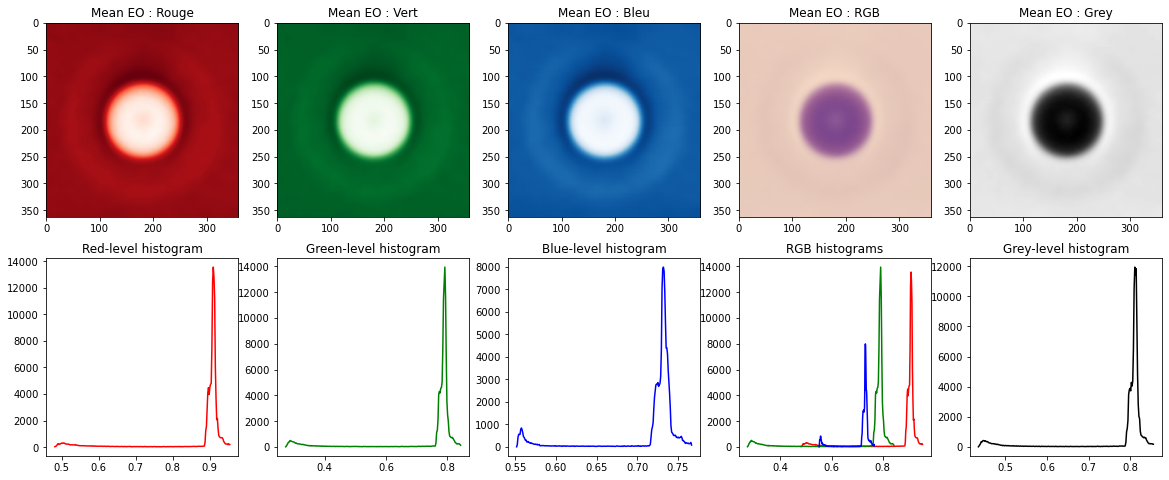

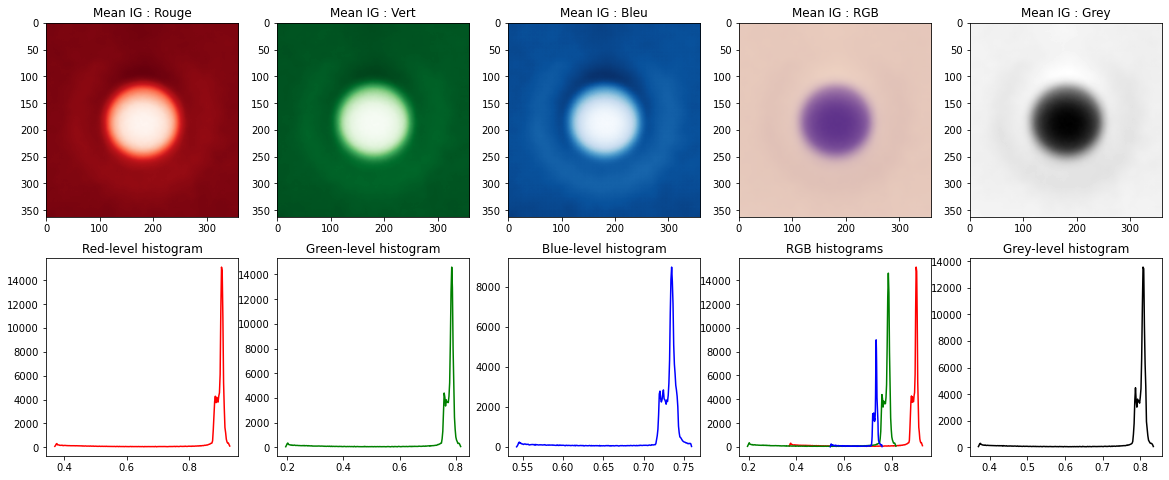

In [11]:
# Long, mais peu gourmand en RAM : à exécuter pour afficher les profils de luminosité
labels = df['label'].unique().tolist()
df_mean = eda.plot_mean_color_cell_ram(barcac, labels)


- La cellule moyenne (première ligne de chaque sous ensemble), quelque soit sa catégorie, a une **symétrie cylindrique forte** comme on pouvait l'espérer : une cellule n'étant pas un disque parfait mais plutôt un "patatoïde", on en déduit qu'en moyenne il n'y a pas d'orientation particulière pour un type de cellule par rapport aux autres. La cellule moyenne se trouve bien au centre de l'image, les globules rouges ont été lissés et n'apparaissent presque plus (leur répartition est donc bien aléatoire), de même que les agglomérats qu'on a pu voir dans les outliers. <br/>


- Les images moyennes des monocytes (MO) et des basophiles (BA) se ressemblent beaucoup. Les autres cellules se différencient bien les unes des autres, soit par leur diamètre, soit par la structure à l'intérieur de la cellule moyenne. <br/>


- On remarque l'existence d'une sorte d'auréole de surbrillance autour de chaque cellule moyenne. Cette auréole correspond à la  région de l'espace située au contact direct de la membrane cellulaire : sur la plupart des images du dataset, la cellule d'intérêt n'est pas en contact direct avec les globules rouges, il y a toujours un petit espace. La présence de cet anneau nous permet de remonter à une taille caractéristique, en pixel, de chaque type de cellule. <br/>


- Les écarts par rapport à la symétrie cylindrique sont visibles sur la deuxième ligne, représentant l'écart-type de luminosité pour chaque pixel de l'image. On peut déceler, pour la plupart des catégories de cellules, une légère modulation selon la variable angulaire (lancer plot_mean_color_cell). <br/>


- La position et la hauteur des pics RGB varie selon le type de cellule, ce à quoi on pouvait s'attendre du fait des disparités entre chaque type de cellule (noyau plus ou moins sombre lorsqu'il y en a un, occupant la totalité ou seulement une partie de la cellule, zones "roses" des éosinophiles etc...) <br/>


Ces différences sont relatives à la nature même de chaque type de cellule et apparaissent sur des propriétés moyennes des images : cela constitue un signal positif quant à la capacité  d'utiliser un algorithme de machine-learning pour trier ces images.

**On peut aller un peu plus loin et tracer le profil radial de luminosité pour chacune des cellules moyennes :**

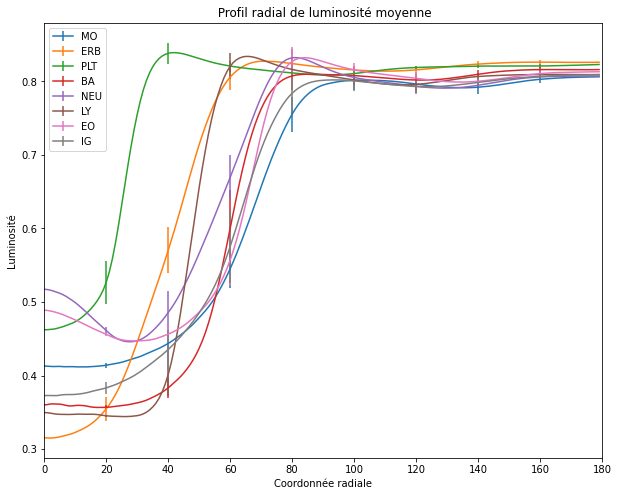

In [12]:
## Noir et blanc + projection en coordonnées polaires : profil radial de luminosité

eda.radial_luminance_mean_profile(df_mean, radius = 180)  # 180px : rayon du cercle inscrit dans une image 360*360

# radius = 180 : warp_polar ne prend en compte que les pixels situés à l'intérieur du cercle de rayon r = 180px
# radius = None : warp_polar prend en compte toute l'image, donc les pixels situés à l'intérieur du cercle dans
## lequel l'image carrée d'origine est inscrite (~ 255 px de rayon). 
## Sauf que dans ce cercle, il y a des zones qui débordent de l'image, pour lesquelles la luminosité est nulle (pas 
# d'information. Donc, au delà d'un certain rayon (180 px pour nous) : il apparait une troisième zone sur le profil
# radial de luminosité, pour laquelle la luminosité décroit en fonction de r. Cette troisième zone correspond à un
# profil de luminosité identique pour les 8 cellules moyennes... Les barres d'erreurs sont énormes car il n'y a que 
# "deux" valeurs de luminosité dans cette région : la valeur moyenne lorsqu'il y a de l'image, et 0 lorsqu'on sort
# du cadre de l'image.


La figure ci-dessus représente l'évolution de la luminance $L(r)$ en fonction de la distance $r$ par rapport au centre de l'image (donc par rapport au centre de la cellule). Cette luminance a été moyennée sur la variable angulaire $\theta$ : les barres d'erreurs représentent l'écart-type de $L(r)$ par rapport aux valeurs de $\theta$. Chaque courbe correspond à une des 8 cellules moyennes calculées plus haut.

Deux zones apparaissent distinctement sur chaque courbe :
- **zone I :** entre $r = 0$ et $r = r_{max}$ tel que $L(r_{max})$ est maximale (l'anneau de surbrillance autour de chaque cellule moyenne). Elle correspond à l'intérieur de la cellule. La luminosité augmente globalement avec le rayon, jusqu'au bord de la cellule, défini par le pic de luminosité en $r_{max}$. Un minima local plus ou moins prononcé d'un type de cellule à l'autre est présent sur certaines classes de cellules. Les plaquettes, les érythroblastes et les granulocytes immatures en sont dépourvus. **Le profil de luminosité est assez différent d'un type de cellule à l'autre et les plaquettes sortent clairement du lot,** du fait de leur petite taille par rapport aux autres cellules. **Les deux profils les plus semblables sont ceux des granulocytes immatures et des monocytes.** L'image moyenne est globalement invariante par rotation dans cette zone (les cellules sont globalement circulaires et il n'y a pas d'orientation privilégiée d'une image à l'autre). <br/>

- **zone II :** entre $r_{max}$ et $r \simeq 180$ : un plateau de luminosité constante, invariante par rotation, d'où la faible importance des barres d'erreur sur chacune des 8 courbes. Cette portion du profil correspond au fond de l'image, avec les globules rouges. Dans un cadre idéal, il faudrait que les profils des 8 classes se confondent dans cette zone, ce qui n'est pas le cas : malgré tout, les valeurs sont proches d'une cellule moyenne à l'autre (5% au plus fort). Plus important, les **écarts** entre les différentes courbes sont plus importants dans la zone I que dans la zone II, donc **plus importants au centre des images qu'à leur périphérie**, y compris pour lorsqu'on compare les types de cellules dont les zones I sont les plus proches : les différences de profils en zone I entre IG et MO sont les plus faibles, mais leurs profils en zone II se confondent pratiquement.

**On peut donc espérer qu'un algorithme de machine-learning privilégiera les différences au centre des images pour les classer, donc qu'il n'y a pas de biais significatif de luminosité d'une classe de cellule sanguine à l'autre.**



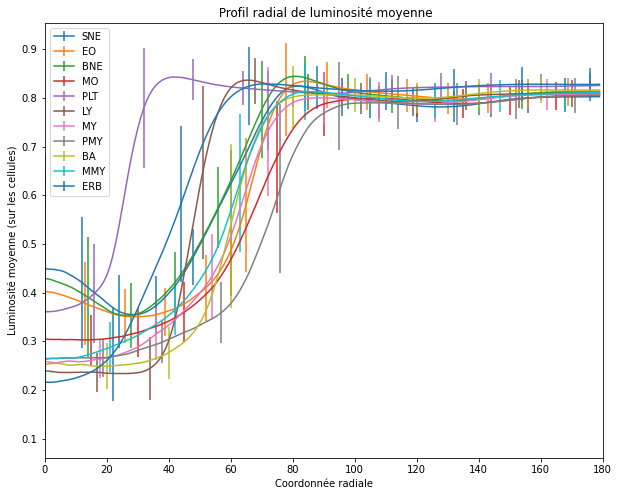

In [25]:
# Lent
# Calcul des barres d'erreur par rapport aux cellules d'une même classe.
## Au niveau du plateau (zone II), les barres d'erreur d'une courbe recouvrent les 7 autres courbes, donc on ne peut pas
## dire qu'il y a une différence significative entre les classes, donc pas de biais de luminosité.

labels = df['label'].unique().tolist()

eda.radial_luminance_profile(barca, labels)

Cette fois-ci, les barres d'erreurs représentent l'écart-type au sein de la classe de cellules considérée. On voit qu'au niveau du plateau de la zone II, les barres d'erreur d'une courbe recouvrent aussi les autres courbes, ce qui signifie qu'il n'y a pas de différences notables de luminosité entre classes de cellule pour la zone II, on peut donc conclure qu'il n'y a pas de biais de luminosité.

Dans la zone I, les choses sont plus complexes. Pour éviter de détailler au cas par cas, retenons que les disparités d'une classe à l'autre sont plus significatives que pour la zone II, certaines classes étant bien séparées des autres.

Ainsi, les différences de luminosité observées entre les distributions de chaque classe de cellules semblent surtout liées à la taille de la cellule et à celle de son noyau, donc à des caractéristiques qui sont pertinentes pour le classement des images.

### Déconvolution

On va utiliser la déconvolution pour décomposer les images sur trois nouveaux canaux de couleur (C1, C2 et C3). La déconvolution des couleurs a été développé pour l'analyse histologique et la librairie utilise l'algorithme développé par G. Landini.  
La déconvolution des couleurs est basée sur la loi de Beer-Lambert et peut séparer les images en trois canaux représentant l'absorbance de chaque coloration histologique. 
Nous avons choisit une matrice de conversion de la coloration `Methyl Blue + Ponceau Fuchsin` qui est proche du MGG original et sépare bien les globules rouges.

In [ ]:
deconv_bag = bag.from_sequence(barca.img_path.to_list()).map(deconvolution_hist)
with diagnostics.ProgressBar():
    res = deconv_bag.compute()
    
res_deconv = pd.concat(res)
res_deconv = res_deconv.reset_index(drop=True)
df_deconv = df.join(res_deconv)

#### Plot d'un exemple de color deconvolution

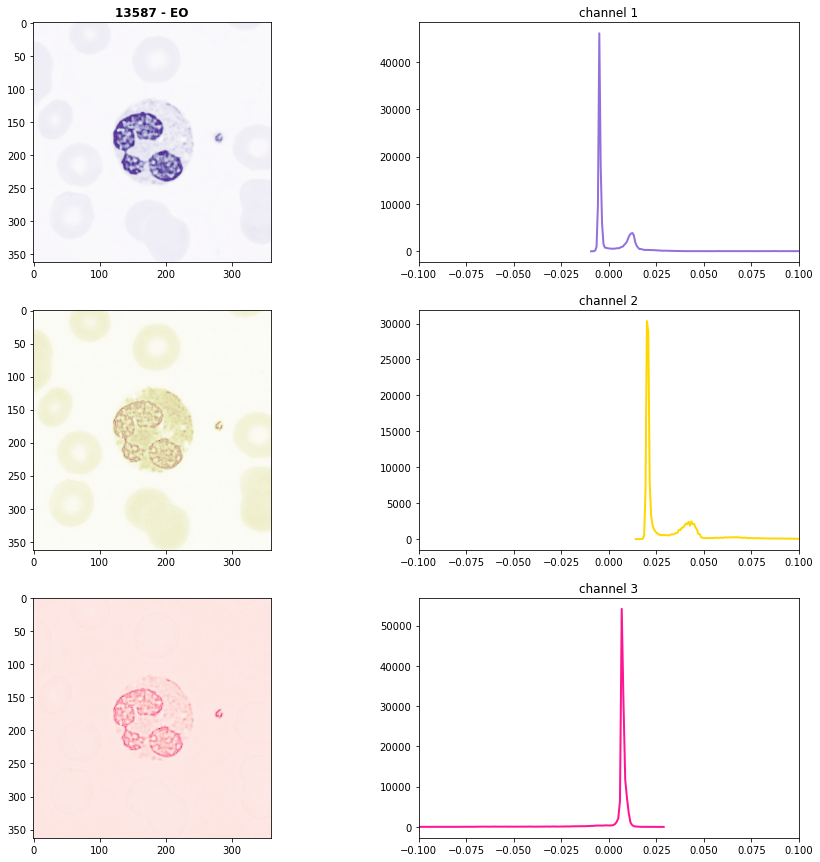

In [24]:
rand = np.random.choice(range(barca.shape[0]))
eda.plot_deconv_single(rand);

Cette technique permet de séparer les images en trois composantes principales:
- le noyau ressort plus sur le canal 1 (en blue)
- les globules rouges sont très présents sur le canal 2 en jaune
- le fond (bkg) est associé au canal 3 en rose

#### Distribution des expositions moyennes par canaux de déconvolution

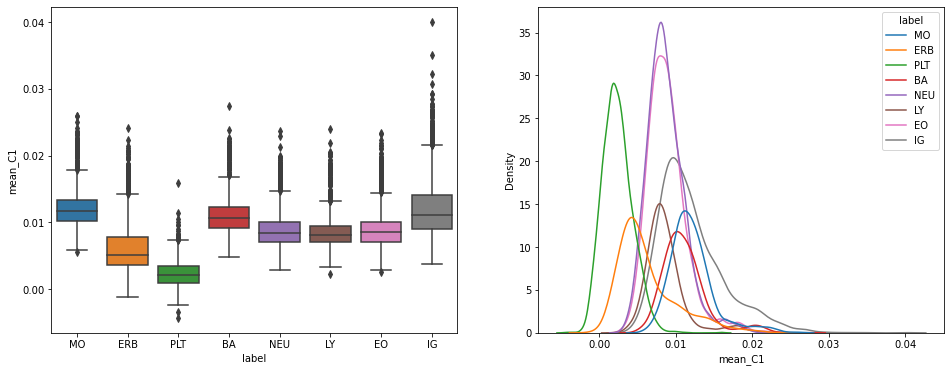

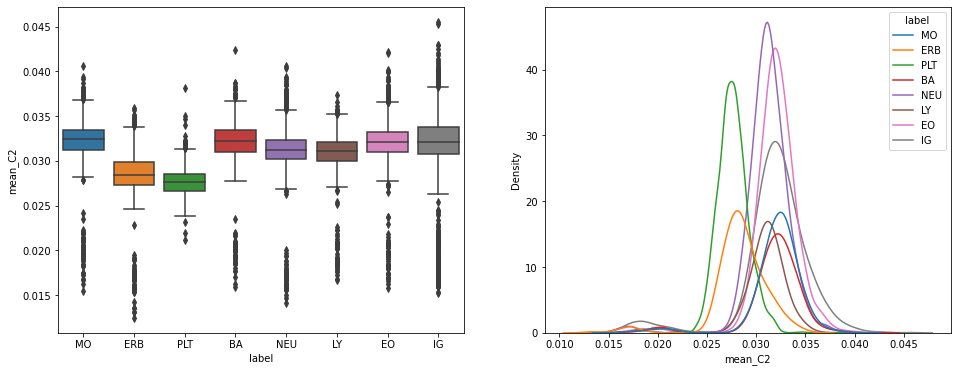

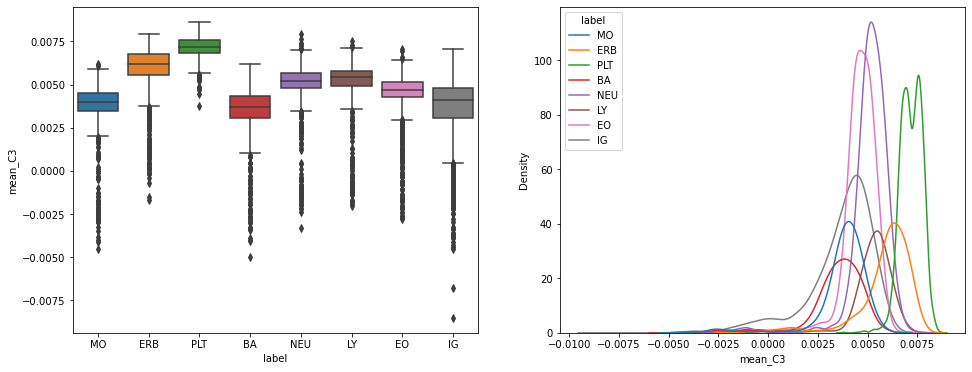

In [15]:
for col in ['mean_C1', 'mean_C2', 'mean_C3']:
    eda.box_plot(col, df_deconv)

Comme précedemment, les plaquettes (PLT) et les érythroblastes (ERB) présentent une intensité plus faible pour le canal **'noyau'** et plus haute pour le canal **'bkg'**. La différence sur le canal 'rbc-red blood cell' est plus faible, ce qui soutient un nombre similaire de globules rouges moyens en concordance avec l'analyse des cellules moyennes.  
La différence de noyau et background peut s'expliquer par la taille des cellules comme précédemment montré par l'analyse radiale.
    toutes les classes présentent des outliers, essentiellement de faible luminosité.

#### Distribution des histogrammes d'exposition par type de cellules

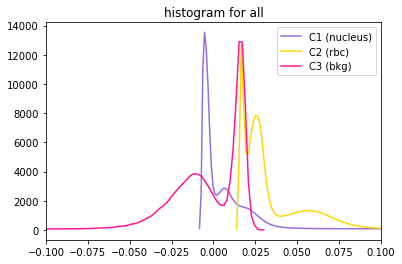

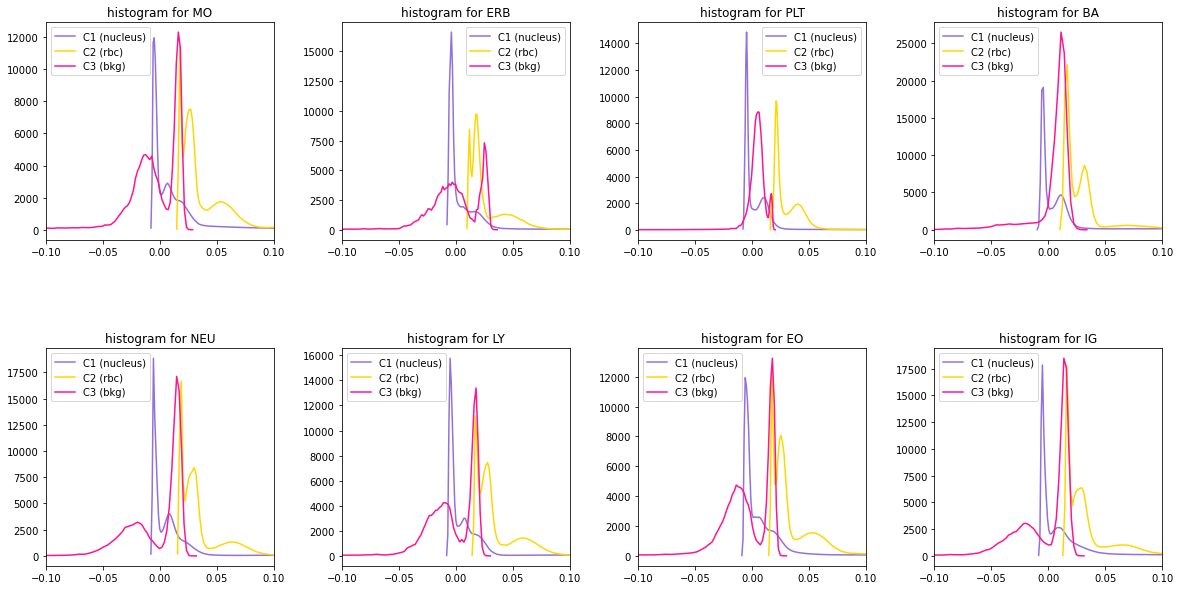

In [52]:
eda.plot_histogram(df_deconv, 'all')

fig = plt.figure(figsize = (20, 10))
gs = fig.add_gridspec(2, 4, wspace = 0.3, hspace = 0.5)
for cell, i in zip(df.label.unique(), [p for p in product(range(2), range(4))]):
    ax = fig.add_subplot(gs[i])
    ax = eda.plot_histogram_per_cell(df_deconv, cell);
    

Les histogrammes révèlent encore une fois des différences significatives entre les plaquettes (PLT) et les érythroblastes(ERB) d'une part, et d'autre part les autres cellules, confirmant ce qui a pu être dit dans la section précédente.
Les basophiles (BA) présentent eux aussi un shift dans la canal background ce qui peux s'expliquer par leurs tailles et la présence d'agglomérats.

## Conclusion

Compte tenu des différences assez visibles entre les **plaquettes** et les autres cellules (taille plus petite, absence de noyau), on s'attend à ce que le futur modèle puisse les **détecter assez précisément**. 

Les données dont nous disposons pour les cellules saines sont de qualité et ne **présentent pas de biais évident**. Il faut toutefois ajouter qu'elles ont été enregistrées avec **le même analyseur, et procéssée dans le même laboratoire avec le même protocole de coloration** : c'est une autre forme de biais, qui pourrait induire un **overfitting** de notre modèle. Lors de la phase de test du modèle et si ce problème apparaît, on pourra essayer d'entraîner le modèle en ajoutant aux données des cellules malades ou provenant d'autres sources.

# Réduction de dimensions

## Preprocessing

### sampling

In [27]:
sample = df.groupby('label').sample(n=300, random_state=42)

In [28]:
# Loading grayscaled images
dfile_bag = bag.from_sequence(sample.img_path.to_list()).map(leuko.load_image, 
                                                          as_grey=True, 
                                                          rescale=0.5)
with diagnostics.ProgressBar():
    images = np.array(dfile_bag.compute())
images_flat = images.reshape(images.shape[0], -1) 

[########################################] | 100% Completed | 37.1s


In [29]:
df_data = pd.DataFrame(images_flat)

### Label encoding

In [30]:
le = preprocessing.LabelEncoder()
target = le.fit_transform(df.label)
target_sample = target[sample.index]

## PCA embedding

In [31]:
# Applying the PCA to our data
pca = PCA(n_components = 0.9)
X_pca = pca.fit_transform(df_data)

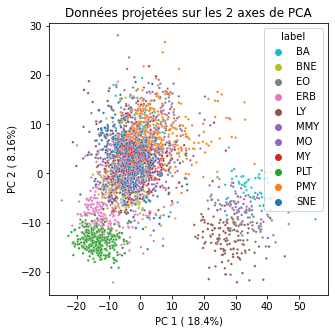

In [32]:
# Plotting our results
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue = sample["label"], s=6, palette = 'tab10_r')

ax.set_xlabel(f'PC 1 ({pca.explained_variance_ratio_[0] * 100: .3g}%)')
ax.set_ylabel(f'PC 2 ({pca.explained_variance_ratio_[1] * 100: .3g}%)')

ax.set_title("Données projetées sur les 2 axes de PCA")
plt.show()

Nous voyons ici que quelques cellules se détachent des autres mais cela n'est pas du au type de cellules (PC1). Sur PC2, nous voyons que les plaquettes se détachent du groupe, ce qui corresponds bien avec l'analyse précédente.

## UMAP emdedding 

Pour obtenir une vision plus locale tout en conservant les distances global nous avons utilisé UMAP.

### Applying our UMAP model


In [37]:
%%time
mapper = umap.UMAP(n_neighbors=30, random_state=42, min_dist=0.7, n_jobs=6).fit(images_flat)

embedding = mapper.transform(images_flat)

CPU times: user 2min 53s, sys: 1.13 s, total: 2min 54s
Wall time: 2min 52s


In [38]:
sample['X_UMAP'] = embedding[:, 0]
sample['Y_UMAP'] = embedding[:, 1]

sample2 = sample.sample(frac=0.035)
sample2
paths = sample2.img_path
x_coord = sample2.X_UMAP.to_list()
y_coord = sample2.Y_UMAP.to_list()

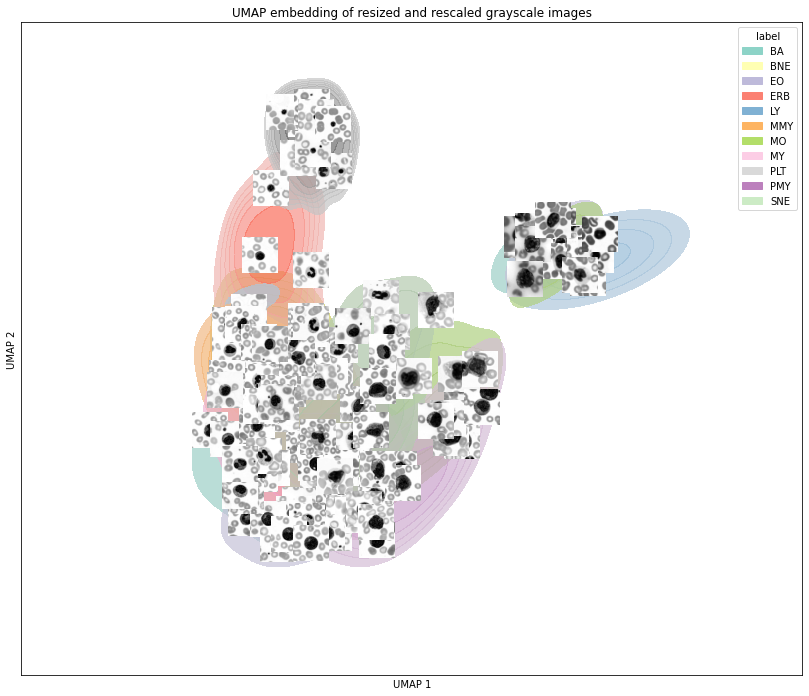

In [39]:
# Plotting the results
fig, ax = plt.subplots(1, figsize=(14, 12))
sns.kdeplot(x=embedding[:, 0], y=embedding[:, 1], hue='label', data=sample, shade=True, thresh=0.2, alpha=0.7, palette='Set3')
plt.setp(ax, xticks=[], yticks=[])

plt.title('UMAP embedding of resized and rescaled grayscale images')


def getImage(path):
    return OffsetImage(leuko.load_image(path, as_grey=True, rescale=0.1),
                      cmap='gray')

for x, y, path in zip(x_coord, y_coord, paths):
    ab = AnnotationBbox(getImage(path), (x, y), frameon=False)
    ax.add_artist(ab)
    
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
plt.show()

Comme avec la PCA, les plaquettes et un groupe de cellules se détachent.

### Par origine

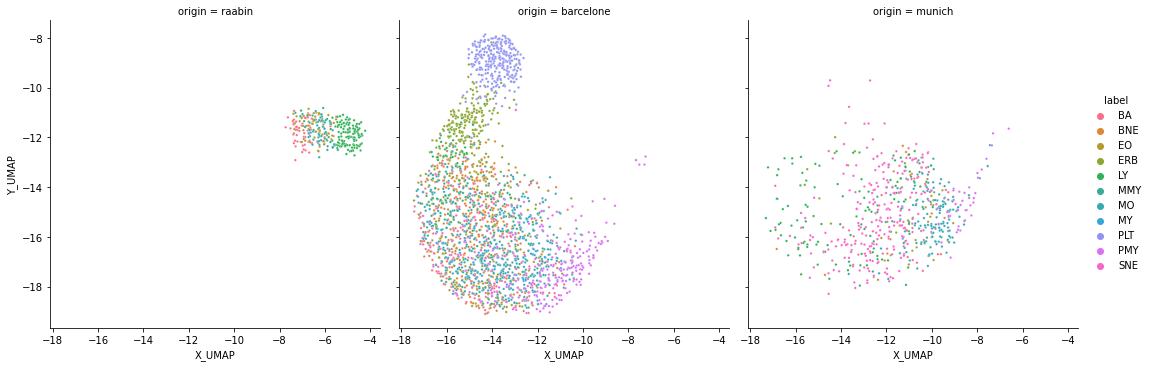

In [41]:
sns.relplot(x='X_UMAP', y='Y_UMAP', hue='label', data=sample,
            col='origin',
                s=6,)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

ax.set_title('UMAP embedding')
plt.show()

Nous voyons bien ici que les plaquettes se détachent du reste uniquement dans le dataset de Barcelone. 

Le groupe de cellules isolés correspond au dataset de Raabin, ce qui pourrait s'expliquer par la large taille des images.

Le dataset de Munich est quant à lui reparti sur les deux composants du UMAP.

# Conclusion

En utilisant la réduction de dimension, nous avons trouvé une séparation cohérente des plaquettes du reste de la cellule. Les plaquettes apparaissent ainsi comme une cellule facile à classer. Ces résultats sont en accord avec les données de l'exploration de luminance et de déconvolution.
L'UMAP a révélé que les cellules ont tendance à se regrouper au sein d'un groupe important. Sur le PCA et l'UMAP, nous avons également pu observer que la taille des cellules et la luminosité contribuent à la variance globale. 